# 15. Modelo hibrido ConvLSTM clasificacion binaria
***

### Caso de estudio #1


### Tecnicas de ajuste de los datos y modelos:

| Ingeniería de datos       | Si / No       |
| :-------                  | :------:    |
| Escalado de datos         | Si          |
| Ajuste de arquitectura         | Si          |
| Regularizacion  | Si          |
| Ajuste de pesos  | No         |
| Sobremuestreo  | No        |

In [1]:
# librerias
import numpy as np
import math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import ConvLSTM2D
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score
from plot_metric.functions import BinaryClassification
from sklearn.metrics import classification_report
from sklearn import preprocessing

import os
import h5py
from sklearn import datasets 
from keras.models import model_from_json

from numba import cuda
from pandas import DataFrame
from numpy import array
from matplotlib import pyplot


Using TensorFlow backend.


In [2]:
# BINARIA funcion para generar matriz de confusion y medidas de desempeño del modelos clasificacion binarios
def model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
   # Medidas de desempeño del modelo
    matriz = confusion_matrix(label_test, label_pred)
    print('Confusion Matrix: \n',confusion_matrix(label_test,label_pred))
    print('\n')
    print("MEDIDAS DE DESEMPEÑO DEL MODELO")
    print('\n')
    print('Exactitud - Accuracy: {}'.format(accuracy_score(label_test,label_pred)))
    print('ROC AUC: {}'.format (metrics.roc_auc_score(label_test, label_pred)))
    print('-'*60)
    print('Precisión por clase: {}'.format(metrics.precision_score(label_test, label_pred, average=None)))
    print('Sensibilidad - Recall por clase: {}'.format(metrics.recall_score(label_test, label_pred, average=None)))
    print('F1 por clase: {}'.format(metrics.f1_score(label_test, label_pred, average=None)))
    print('-'*60)
    print('F1 Macro: {}'.format(metrics.f1_score(label_test, label_pred, average='macro')))
    print('F1 Micro: {}'.format(metrics.f1_score(label_test, label_pred, average='micro')))
    print('F1 Weighted: {}'.format(metrics.f1_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Sensibilidad - Recall Macro: {}'.format(metrics.recall_score(label_test, label_pred, average='macro')))
    print('Sensibilidad - Recall Micro: {}'.format(metrics.recall_score(label_test, label_pred, average='micro')))
    print('Sensibilidad - Recall Weighted: {}'.format(metrics.recall_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Precisión Macro: {}'.format(metrics.precision_score(label_test, label_pred, average='macro')))
    print('Precisión Micro: {}'.format(metrics.precision_score(label_test, label_pred, average='micro')))
    print('Precisión Weighted: {}'.format(metrics.precision_score(label_test, label_pred, average='weighted')))
   
    TP = matriz[1][1]
    TN = matriz[0][0]
    FP = matriz[0][1]
    FN = matriz[1][0]
    print('-'*60)
    print('Verdaderos positivos - True Positives:', TP)
    print('Verdaderos negativos - True Negatives:', TN)
    print('Falsos positivos - False Positives:', FP)
    print('Falsos negativos - False Negatives:', FN)
        # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
        # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
        # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
        # calculate the specificity
    conf_specificity = (TN / float(TN + FN))
        # calculate precision
    conf_precision = (TP / float(TP + FP))
        # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
        # calculate FPR tasa de falsos positivos
    conf_FPR = 1 - conf_specificity
    print('-'*60)
    print(f'Error de clasificacion: {round(conf_misclassification,3)}') 
    print(f'Especificidad - Specificity: {round(conf_specificity,3)}') 
    print(f'Tasa de falsos positivos FPR: {round(conf_FPR,3)}')
    print('-'*60)
    print(classification_report(label_test, label_pred))
    # curva ROC clasificacion binaria
    bc = BinaryClassification(label_test, label_pred, labels=["Class 0", "Class 1"])
    plt.figure(figsize=(5,5))
    bc.plot_roc_curve()
    print('\n')
    print("CURVA ROC")
    plt.show()

In [3]:
# grtafica de perdida y precision 
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

### Preparar datos

In [4]:
columns=["id","ciclo","set1","set2","set3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21","sensor22","sensor23"]
train=pd.read_csv("train_FD001.txt",sep=" ",names=columns)
test=pd.read_csv("test_FD001.txt",sep=" ",names=columns)
rul=pd.read_csv("RUL_FD001.txt",sep=" ",header=None)
train.drop(['sensor22','sensor23'], axis=1, inplace=True)
test.drop(['sensor22','sensor23'], axis=1, inplace=True)
rul.drop([1], axis=1, inplace=True)
rul.columns = ['ttf']
rul2=pd.DataFrame(train.groupby('id')['ciclo'].max()).reset_index()
rul2.columns = ['id', 'falla']
train= train.merge(rul2, on=['id'], how='left')
train['ttf'] = train['falla'] - train['ciclo']
train.drop('falla', axis=1, inplace=True)
train['clase1']=np.where(train['ttf'] <= 30, 1, 0)
train.head()


,id,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,ttf,clase1
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


In [5]:
rul3=pd.DataFrame(test.groupby('id')['ciclo'].max()).reset_index()
rul3.columns = ['id', 'falla']
rul['id'] = rul.index + 1
rul['falla'] = rul3['falla'] + rul['ttf']
rul.drop('ttf', axis=1, inplace=True)
test=test.merge(rul, on=['id'], how='left')
test['ttf'] = test['falla'] - test['ciclo']
test.drop('falla', axis=1, inplace=True)
test['clase1']=np.where(test['ttf'] <= 30, 1, 0)
test.head()


,id,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,ttf,clase1
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138,0


In [6]:
variables=['set1','set2','set3','sensor1','sensor2','sensor3','sensor4','sensor5','sensor6','sensor7','sensor8','sensor9','sensor10','sensor11','sensor12','sensor13','sensor14','sensor15','sensor16','sensor17','sensor18','sensor19','sensor20','sensor21']
objetivo='clase1'
# escalado de datos sin incluir id, ciclo, ttf y clase
scaler = MinMaxScaler()
train[variables]=scaler.fit_transform(train[variables])
test[variables]=scaler.transform(test[variables])
train.head()

,id,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,ttf,clase1
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0


In [7]:
test.head()

,id,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,ttf,clase1
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,138,0


In [8]:
print("numero de dimensiones =", train.ndim)
print("tamaño de la tabla =", train.shape)
print("total datos =", train.size)

numero de dimensiones = 2
tamaño de la tabla = (20631, 28)
total datos = 577668


In [9]:
print("numero de dimensiones =", test.ndim)
print("tamaño de la tabla =", test.shape)
print("total datos =", test.size)

numero de dimensiones = 2
tamaño de la tabla = (13096, 28)
total datos = 366688


In [10]:
# funcionar para adaptar datos como lo requiere LSTM
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)


def gen_label(id_df, seq_length, seq_cols,label):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

In [11]:
pasos_de_tiempo=40
columnas_secuencia=variables

# generate data_train
data_train=np.concatenate(list(list(gen_sequence(train[train['id']==id], pasos_de_tiempo, columnas_secuencia)) for id in train['id'].unique()))
# generate label_train
label_train=np.concatenate(list(list(gen_label(train[train['id']==id], pasos_de_tiempo, columnas_secuencia,'clase1')) for id in train['id'].unique()))

# generate data_test
data_test=np.concatenate(list(list(gen_sequence(test[test['id']==id], pasos_de_tiempo, columnas_secuencia)) for id in test['id'].unique()))
# generate label_test
label_test=np.concatenate(list(list(gen_label(test[test['id']==id], pasos_de_tiempo, columnas_secuencia,'clase1')) for id in test['id'].unique()))


In [12]:
print("numero de dimensiones Data_train =", data_train.ndim)
print("tamaño de la tabla Data_train =", data_train.shape)
print("total datos Data_train =", data_train.size)
print('-'*60)
print("numero de dimensiones Label_train =", label_train.ndim)
print("tamaño de la tabla Label_train =", label_train.shape)
print("total datos Label_train =", label_train.size)
print('-'*60)
print("numero de dimensiones Data_test =", data_test.ndim)
print("tamaño de la tabla Data_test =", data_test.shape)
print("total datos Data_test =", data_test.size)
print('-'*60)
print("numero de dimensiones Label_test =", label_test.ndim)
print("tamaño de la tabla Label_test =", label_test.shape)
print("total datos Label_test =", label_test.size)


numero de dimensiones Data_train = 3
tamaño de la tabla Data_train = (20531, 40, 24)
total datos Data_train = 19709760
------------------------------------------------------------
numero de dimensiones Label_train = 1
tamaño de la tabla Label_train = (20531,)
total datos Label_train = 20531
------------------------------------------------------------
numero de dimensiones Data_test = 3
tamaño de la tabla Data_test = (12996, 40, 24)
total datos Data_test = 12476160
------------------------------------------------------------
numero de dimensiones Label_test = 1
tamaño de la tabla Label_test = (12996,)
total datos Label_test = 12996


In [13]:
# adaptar datos como se requiere en la arquitectura ConvLSTM
n_steps, n_length = 4, 10

data_train = data_train.reshape((data_train.shape[0], n_steps, 1, n_length, data_train.shape[2]))
data_test = data_test.reshape((data_test.shape[0], n_steps, 1, n_length, data_test.shape[2]))

print("numero de dimensiones Data_train =", data_train.ndim)
print("tamaño de la tabla Data_train =", data_train.shape)
print("total datos Data_train =", data_train.size)
print('-'*60)
print("numero de dimensiones Data_test =", data_test.ndim)
print("tamaño de la tabla Data_test =", data_test.shape)
print("total datos Data_test =", data_test.size)


numero de dimensiones Data_train = 5
tamaño de la tabla Data_train = (20531, 4, 1, 10, 24)
total datos Data_train = 19709760
------------------------------------------------------------
numero de dimensiones Data_test = 5
tamaño de la tabla Data_test = (12996, 4, 1, 10, 24)
total datos Data_test = 12476160


## Modelo ConvLSTM

In [18]:
model_path_clf = 'classification_model.h5'  

# model
verbose, epochs, batch_size = 0, 50, 32

n_steps=data_train.shape[1]
n_length= data_train.shape[3]
n_features =data_train.shape[4]
n_outputs= 1

model = Sequential()
model.add(ConvLSTM2D(128, (1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# fit network

history = model.fit(data_train, label_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=2, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=2)])
print(history.history.keys())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_2 (ConvLSTM2D)  (None, 1, 8, 128)         233984    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 8, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                51250     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 285,285
Trainable params: 285,285
Non-trainable params: 0
_________________________________________________________________
None
Train on 18477 samples, validate on 2054 samples
Epoch 1/50
 - 9s - loss: 0.1326 - acc: 0.9432 - val_loss: 0.0838 - val_acc: 0.9567

In [19]:
# evaluar modelo en train y test
_, train_acc = model.evaluate(data_train, label_train, batch_size=32, verbose=1)
_, test_acc = model.evaluate(data_test, label_test, batch_size=32, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

12996/12996 [==============================] - 3s 212us/step
Train: 0.974, Test: 0.988


In [20]:
label_pred=model.predict_classes(data_test)

Confusion Matrix: 
 [[12548   116]
 [   35   297]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9883810403200985
ROC AUC: 0.9427092450661776
------------------------------------------------------------
Precisión por clase: [0.99721847 0.71912833]
Sensibilidad - Recall por clase: [0.99084018 0.89457831]
F1 por clase: [0.99401909 0.79731544]
------------------------------------------------------------
F1 Macro: 0.8956672638094021
F1 Micro: 0.9883810403200985
F1 Weighted: 0.9889940364752994
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9427092450661776
Sensibilidad - Recall Micro: 0.9883810403200985
Sensibilidad - Recall Weighted: 0.9883810403200985
------------------------------------------------------------
Precisión Macro: 0.8581733993306238
Precisión Micro: 0.9883810403200985
Precisión Weighted: 0.9901142891155214
------------------------------------------------------------
Verdaderos positivos - True Positives: 297
Verdader

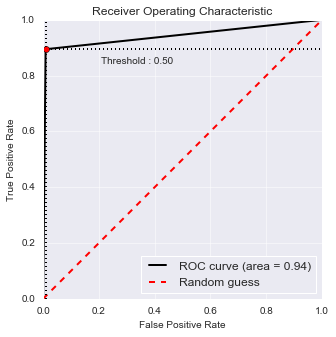

In [21]:
# metricas de desempeño
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

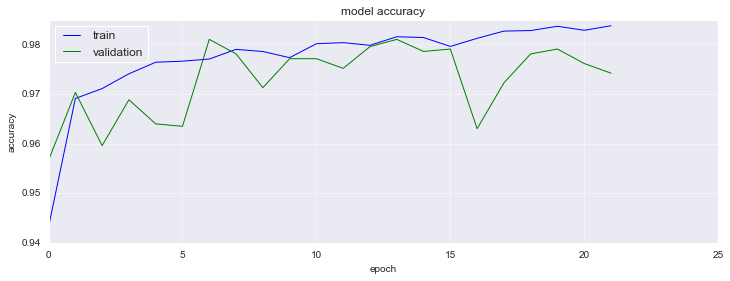

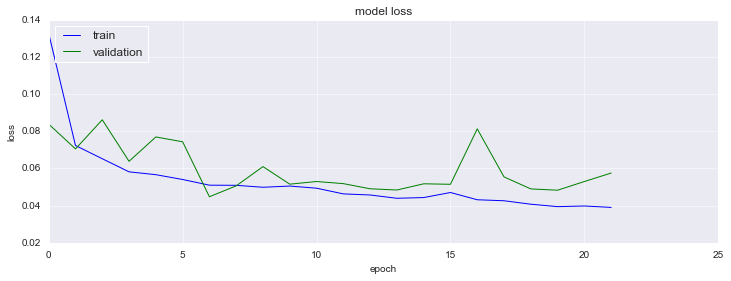

In [22]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')


En la grafica de perdida del modelo se observa fala de ajuste o posible sobreajuste

In [27]:
model_path_clf = 'classification_model.h5'  

# model
verbose, epochs, batch_size = 0, 50, 32

n_steps=data_train.shape[1]
n_length= data_train.shape[3]
n_features =data_train.shape[4]
n_outputs= 1

model = Sequential()
model.add(ConvLSTM2D(128, (1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# fit network

history = model.fit(data_train, label_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=2, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=2)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_4 (ConvLSTM2D)  (None, 1, 8, 128)         233984    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 8, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                51250     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 285,285
Trainable params: 285,285
Non-trainable params: 0
_________________________________________________________________
None
Train on 18477 samples, validate on 2054 samples
Epoch 1/50
 - 9s - loss: 0.1438 - acc: 0.9412 - val_loss: 0.0717 - val_acc: 0.9645

In [28]:
label_pred=model.predict_classes(data_test)

Confusion Matrix: 
 [[12609    55]
 [   71   261]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9903047091412742
ROC AUC: 0.8909007793650914
------------------------------------------------------------
Precisión por clase: [0.99440063 0.82594937]
Sensibilidad - Recall por clase: [0.99565698 0.78614458]
F1 por clase: [0.99502841 0.80555556]
------------------------------------------------------------
F1 Macro: 0.9002919823232323
F1 Micro: 0.9903047091412742
F1 Weighted: 0.9901880745746164
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8909007793650914
Sensibilidad - Recall Micro: 0.9903047091412742
Sensibilidad - Recall Weighted: 0.9903047091412742
------------------------------------------------------------
Precisión Macro: 0.910174999001717
Precisión Micro: 0.9903047091412742
Precisión Weighted: 0.9900973206970436
------------------------------------------------------------
Verdaderos positivos - True Positives: 261
Verdadero

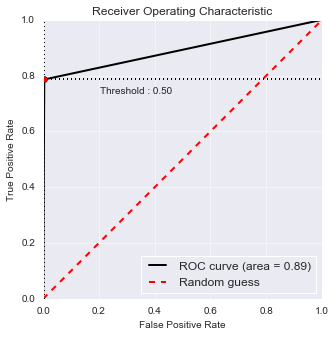

In [29]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

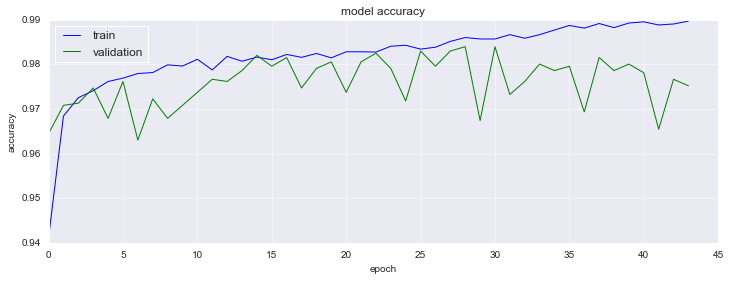

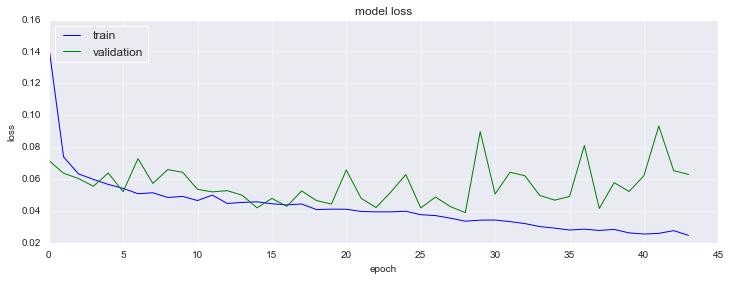

In [30]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')


Se evidencia Overfit, Un modelo sobreajustado es aquel en el que el rendimiento en el conjunto de train es bueno y continúa mejorando, mientras que el rendimiento en el conjunto de validación mejora hasta cierto punto y luego comienza a degradarse.

Esto se puede diagnosticar a partir de un diagrama donde la pérdida del train desciende y la pérdida de validación desciende, golpea un punto de inflexión y comienza a subir nuevamente.

In [31]:
# cargar el mejor modelo guardado durante el entrenamiento

from keras.models import load_model
# load the saved model
saved_model = load_model('classification_model.h5')

In [32]:
label_pred=model.predict_classes(data_test)

Confusion Matrix: 
 [[12609    55]
 [   71   261]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9903047091412742
ROC AUC: 0.8909007793650914
------------------------------------------------------------
Precisión por clase: [0.99440063 0.82594937]
Sensibilidad - Recall por clase: [0.99565698 0.78614458]
F1 por clase: [0.99502841 0.80555556]
------------------------------------------------------------
F1 Macro: 0.9002919823232323
F1 Micro: 0.9903047091412742
F1 Weighted: 0.9901880745746164
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8909007793650914
Sensibilidad - Recall Micro: 0.9903047091412742
Sensibilidad - Recall Weighted: 0.9903047091412742
------------------------------------------------------------
Precisión Macro: 0.910174999001717
Precisión Micro: 0.9903047091412742
Precisión Weighted: 0.9900973206970436
------------------------------------------------------------
Verdaderos positivos - True Positives: 261
Verdadero

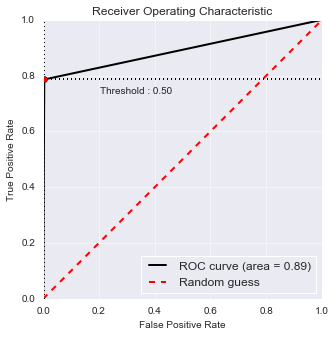

In [33]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

La red hibrida ConvLSTM a pesar de obtener un valor de F1-Score del 90% presenta un problema
de sobreajuste que afecta considerablemente el desempeñoo de la red neuronal cuando
se evalua en los datos de prueba, con el modelo ConvLSTM se obtiene el Recall de la clase
minoritaria con un valor del 79%, es decir 13 puntos porcentuales por debajo de la red
CNN-LSTM, este bajo valor del Recall de la clase 1 se interpreta como un modelo de bajo
desempeño con una predisposicion a producir un numero de falsos negativos signicativamente
altos que es inadecuado para este caso de estudio.